In [45]:
import pandas as pd
import numpy as np
import glob
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support




Data is present in Epl/data/ and seperate features required are taken to reduce the difficulties in cleaning..empty coloumns if any are filled with NaN.

In [37]:
# Load only Premier League CSVs (E0)
files = glob.glob("C:/Epl/data/E0*.csv")
print(files)
features=["Date","HomeTeam","AwayTeam","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
target ="FTR"
dfs = []
for f in files:
    df = pd.read_csv(f, encoding='cp1252', on_bad_lines='skip')
    for col in features:
        if col not in df.columns:
         df[col] = pd.NA
    df = df[features + [target]]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")
print("Shape:", data.shape)
print(data.head())


['C:/Epl/data\\E02000.csv', 'C:/Epl/data\\E02001.csv', 'C:/Epl/data\\E02002.csv', 'C:/Epl/data\\E02003.csv', 'C:/Epl/data\\E02004.csv', 'C:/Epl/data\\E02005.csv', 'C:/Epl/data\\E02006.csv', 'C:/Epl/data\\E02007.csv', 'C:/Epl/data\\E02008.csv', 'C:/Epl/data\\E02009.csv', 'C:/Epl/data\\E02010.csv', 'C:/Epl/data\\E02011.csv', 'C:/Epl/data\\E02012.csv', 'C:/Epl/data\\E02013.csv', 'C:/Epl/data\\E02014.csv', 'C:/Epl/data\\E02015.csv', 'C:/Epl/data\\E02016.csv', 'C:/Epl/data\\E02017.csv', 'C:/Epl/data\\E02018.csv', 'C:/Epl/data\\E02019.csv', 'C:/Epl/data\\E02020.csv', 'C:/Epl/data\\E02021.csv', 'C:/Epl/data\\E02022.csv', 'C:/Epl/data\\E02023.csv', 'C:/Epl/data\\E02024.csv']
Shape: (9411, 18)
        Date  HomeTeam       AwayTeam  HTHG  HTAG    HS    AS   HST  AST  \
0 2000-08-19  Charlton       Man City   2.0   0.0  17.0   8.0  14.0  4.0   
1 2000-08-19   Chelsea       West Ham   1.0   0.0  17.0  12.0  10.0  5.0   
2 2000-08-19  Coventry  Middlesbrough   1.0   1.0   6.0  16.0   3.0  9.0   
3 

C:\Users\arnas\AppData\Local\Temp\ipykernel_22612\2351140533.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")


Now that data is ready we have to clean it by checking for duplicates and null values.

In [38]:
print(data.isnull().sum())
print((data.isnull().mean()*100).round(2))

Date        1
HomeTeam    1
AwayTeam    1
HTHG        1
HTAG        1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
FTR         1
dtype: int64
Date        0.01
HomeTeam    0.01
AwayTeam    0.01
HTHG        0.01
HTAG        0.01
HS          0.01
AS          0.01
HST         0.01
AST         0.01
HF          0.01
AF          0.01
HC          0.01
AC          0.01
HY          0.01
AY          0.01
HR          0.01
AR          0.01
FTR         0.01
dtype: float64


This shows that the dataset has only a very few negligable output there is 1 missing value and that missing value exists in all features so we could drop that row.

In [39]:
data = data.dropna()
print("After dropping missing:",data.shape)
print("Remaining NaN:",data.isnull().sum().sum())

After dropping missing: (9410, 18)
Remaining NaN: 0


In [40]:
duplicates = data.duplicated().sum()
print("Number of duplicated rows:",duplicates)
data.to_csv("match_winner_cleaned.csv",index = False)

Number of duplicated rows: 0


In [41]:
print(data.columns)
data = data.drop(columns=["Date"])
categorical_col = data.select_dtypes(include ='object').columns
encoders = {}
for c in categorical_col:
    le = LabelEncoder()
    data[c]=le.fit_transform(data[c])
    encoders[c]=le
print(data.head())

Index(['Date', 'HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HS', 'AS', 'HST',
       'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'FTR'],
      dtype='object')
   HomeTeam  AwayTeam  HTHG  HTAG    HS    AS   HST  AST    HF    AF   HC  \
0        12        26   2.0   0.0  17.0   8.0  14.0  4.0  13.0  12.0  6.0   
1        13        43   1.0   0.0  17.0  12.0  10.0  5.0  19.0  14.0  7.0   
2        14        28   1.0   1.0   6.0  16.0   3.0  9.0  15.0  21.0  8.0   
3        16        36   1.0   2.0   6.0  13.0   4.0  6.0  11.0  13.0  5.0   
4        22        17   2.0   0.0  17.0  12.0   8.0  6.0  21.0  20.0  6.0   

    AC   HY   AY   HR   AR  FTR  
0  6.0  1.0  2.0  0.0  0.0    2  
1  7.0  1.0  2.0  0.0  0.0    2  
2  4.0  5.0  3.0  1.0  0.0    0  
3  8.0  1.0  1.0  0.0  0.0    1  
4  4.0  1.0  3.0  0.0  0.0    2  


I have done label encoding for all categorical coloumns and the encoder function is also saved in encoders[] to decode for further use

In [42]:
#splitting data into label and feature input

y = data['FTR']

X = data.drop('FTR', axis=1)


In [43]:

# Split data: 80% training, 20% testing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Stratified split to preserve class ratios
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_split, y_train_split)
X_train_res = X_train_res.astype(np.float32)
y_train_res = y_train_res.astype(np.int64)
print(X_train_res.shape)
print(y_train_res.shape)




print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))


(10344, 16)
(10344,)
Class distribution after SMOTE: {np.int64(0): np.int64(3448), np.int64(1): np.int64(3448), np.int64(2): np.int64(3448)}


Random state fixed as 42 for accuracy and hyperparameter tuning and shufling is done 

In [32]:
weights = compute_sample_weight(class_weight='balanced', y=y_train_res)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective='multi:softprob',  # for 3-class classification
    num_class=3,
    eval_metric='mlogloss',
    random_state = 42
)
param_grid = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',   # macro F1 helps balance all classes
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res,sample_weight=weights)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.8}


In [34]:
from sklearn.metrics import f1_score

# Get predicted probabilities
y_proba = best_model.predict_proba(X_test_split)

# Custom thresholds per class
thresholds = [0.5, 0.5, 0.5]  # start with 0.5 for all classes

def predict_with_thresholds(probs, thresholds):
    preds = []
    for p in probs:
        # Assign class if probability > threshold, else take max
        assigned = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if assigned:
            preds.append(assigned[0])
        else:
            preds.append(np.argmax(p))
    return np.array(preds)

y_pred = predict_with_thresholds(y_proba, thresholds)

print("F1 score macro:", f1_score(y_test_split, y_pred, average='macro'))

F1 score macro: 0.5640866037031859


In [35]:


# Accuracy
print("Accuracy:", accuracy_score(y_test_split, y_pred))

# Full classification report
print(classification_report(y_test_split, y_pred))


Accuracy: 0.6227417640807651
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       556
           1       0.36      0.24      0.29       464
           2       0.70      0.79      0.74       862

    accuracy                           0.62      1882
   macro avg       0.57      0.57      0.56      1882
weighted avg       0.60      0.62      0.61      1882



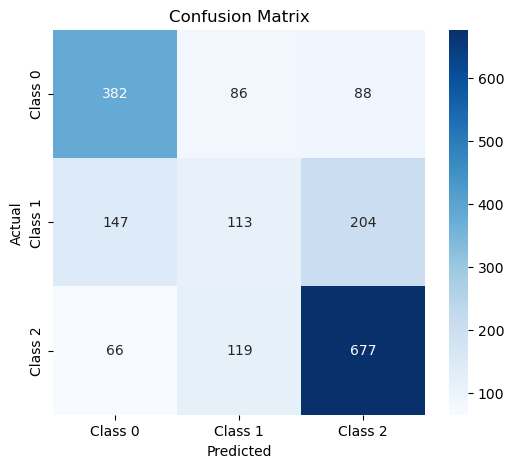

In [44]:
cm = confusion_matrix(y_test_split, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0','Class 1','Class 2'], 
            yticklabels=['Class 0','Class 1','Class 2'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


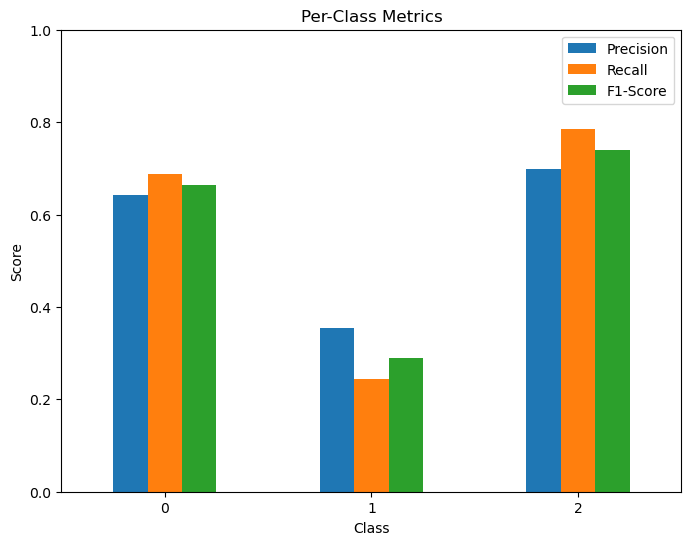

In [47]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test_split, y_pred, average=None)

metrics_df = {
    "Class": ['0','1','2'],
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}

metrics_df = pd.DataFrame(metrics_df)

metrics_df.plot(x="Class", kind="bar", figsize=(8,6))
plt.title("Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()